# Intro

## Standard modules

In [1]:
import os, sys
import pathlib
import requests

In [2]:
import numpy as np

In [3]:
from tqdm.auto import tqdm, trange

In [4]:
from sentence_transformers import util

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1

In [6]:
from sklearn.decomposition import PCA

In [7]:
import seaborn

In [8]:
import pymannkendall as mk

In [9]:
from scipy.spatial.distance import cosine

In [10]:
import requests
import re
from bs4 import BeautifulSoup  # Per pulizia HTML nelle REST API

In [147]:
import datetime as dt

## Personal modules

In [12]:
from toolbox.updater import time_is_now

In [13]:
from file2text import file2text

In [14]:
from first_rough_cleaning import first_text_cleaner

In [15]:
from file_handler import *

In [16]:
from jina4lote import jina4lote

/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


## Folders

In [17]:
VECTOR_FOLDER='./NewProcessedData/vectors/'

In [18]:
BENCHMARK_FOLDER='./NewProcessedData/benchmarks/'

In [19]:
PCA_CENTR_VECTOR_FOLDER='./NewProcessedData/pca_centr_vectors/'

## Witten's vector

In [20]:
wittenvecfile=[file for file in os.listdir(BENCHMARK_FOLDER) if file.startswith('Witten') and file.endswith('.txt')][0]

In [21]:
wittenvec=np.genfromtxt(BENCHMARK_FOLDER+wittenvecfile)

## Load vectors

In [22]:
vecfiles=os.listdir(PCA_CENTR_VECTOR_FOLDER)

In [23]:
vecfiles.sort()

### Goals' vectors

#### Load files

In [24]:
goalvecfiles=[vecfile for vecfile in vecfiles if vecfile.startswith('Goal')]

In [25]:
goalvecfiles.sort()

In [26]:
goalvecfiles

['Goal-01-Fast-Facts.txt',
 'Goal-02-Fast-Facts.txt',
 'Goal-03-Fast-Facts.txt',
 'Goal-04-Fast-Facts.txt',
 'Goal-05-Fast-Facts.txt',
 'Goal-06-Fast-Facts.txt',
 'Goal-07-Fast-Facts.txt',
 'Goal-08-Fast-Facts.txt',
 'Goal-09-Fast-Facts.txt',
 'Goal-10-Fast-Facts.txt',
 'Goal-11_Fast-Facts.txt',
 'Goal-12_Fast-Facts.txt',
 'Goal-13_Fast-Facts.txt',
 'Goal-14_Fast-Facts.txt',
 'Goal-15-Fast-Facts.txt',
 'Goal-16-Fast-Facts.txt',
 'Goal-17-Fast-Facts.txt',
 'Goal-Fast-Facts.txt']

In [27]:
goalvecs=[np.genfromtxt(PCA_CENTR_VECTOR_FOLDER+goalvecfile) for goalvecfile in goalvecfiles]

### Reports' vectors

In [28]:
reports_files=[vecfile for vecfile in vecfiles if vecfile[:4].isnumeric()]

In [29]:
reports_files.sort()

In [30]:
years, k_y=np.unique([rf[:4] for rf in reports_files], return_counts=True)

In [31]:
np.vstack((years, k_y)).T

array([['2015', '40'],
       ['2016', '44'],
       ['2017', '51'],
       ['2018', '56'],
       ['2019', '67'],
       ['2020', '69'],
       ['2021', '76'],
       ['2022', '80'],
       ['2023', '90']], dtype='<U21')

In [32]:
vectors=np.zeros(len(reports_files), dtype=[('year', 'i4'), ('sector', 'U2'), ('company', 'U100'), ('vector', object)])

In [33]:
for i_rf, reports_file in enumerate(reports_files):
    # info from the filename
    splitted_filename=reports_file.split('_')
    
    year=int(splitted_filename[0])
    sector=splitted_filename[1]
    if splitted_filename[-1]=='PLC.txt':
        company='_'.join(splitted_filename[2:-1])
    else:
        company='_'.join(splitted_filename[2:])
        company=company.replace('.txt', '')
    company=company.lower()
    # get the vector
    vector=np.genfromtxt(PCA_CENTR_VECTOR_FOLDER+reports_file)
    
    # organize data
    vectors[i_rf]['year']=year
    vectors[i_rf]['sector']=sector
    vectors[i_rf]['company']=company
    vectors[i_rf]['vector']=vector

## Sector helper

In [34]:
rtf_files=os.listdir('./rtf')
rtf_files.sort()

In [35]:
sec_helper={}
for file in rtf_files:
    splitted_name=file.split('_')
    if splitted_name[0].isnumeric():
        if splitted_name[0] not in sec_helper.keys():
            sec_helper[splitted_name[0].zfill(2)]=splitted_name[1]

In [36]:
sec_helper

{'10': 'Telecommunications',
 '11': 'Utilities',
 '01': 'Basic Materials',
 '02': 'Consumer Discretionary',
 '03': 'Consumer Staples',
 '04': 'Energy',
 '05': 'Financials',
 '06': 'Health Care',
 '07': 'Industrials',
 '08': 'Real Estate',
 '09': 'Technology'}

## SDG helper

In [37]:
sdg_helper={'01':'No Poverty', 
 '02': 'Zero hunger', 
 '03': 'Good health and well-being', 
 '04': 'Quality education',
 '05': 'Gender equality',
 '06': 'Clean water and sanitation',
 '07': 'Affordable and clean energy',
 '08': 'Decent work and economic growth',
 '09': 'Industry, Innovation, Technology and Infrastructure',
 '10': 'Reduced inequality',
 '11': 'Sustainable cities and communities',
 '12': 'Responsible consumption and production',
 '13': 'Climate action',
 '14': 'Life below water',
 '15': 'Life on land',
 '16': 'Peace, justice and strong institutions',
 '17': 'Partnerships for the goals'
}

# The Wikipedia benchmark

## Function

### get_wikipedia_texts: DeepSeek + Fabio

In [38]:
USER_AGENT = "YourProject/1.0 (your@email.com)"  # Obbligatorio per policy API

#### clean_wiki_text

In [69]:
def clean_wiki_text(text):
    # Rimozione sezioni indesiderate (bibliografia, note, etc.)
    text = re.sub(r'==\s*References\s*==.*|\=\=\s*Notes\s*\=\=.*|\=\=\s*External links\s*\=\=.*', '', text, flags=re.DOTALL)
    
    # Conversione markup Wiki -> Markdown
    text = re.sub(r"'''(.*?)'''", r"**\1**", text)  # Bold -> **bold**
    text = re.sub(r"''(.*?)''", r"*\1*", text)      # Italic -> *italic*
    
    # Rimozione complessa di template {{...}} e tag <...>
    text = re.sub(r'\{\{[^{}]*?\}\}|\<[^>]*?\>', '', text)
    
    # Pulizia link [[...]] -> mantiene solo testo ([[testo|alias]] -> testo)
    text = re.sub(r'\[\[([^|\]]+?)(?:\|.*?)?\]\]', r'\1', text)
    
    # Rimozione riferimenti [1], [2-3], etc.
    text = re.sub(r'\[\d+(?:\-\d+)?\]', '', text)
    
    # Normalizzazione spazi e newline
    text = re.sub(r'\n{3,}', '\n\n', text)
    text = re.sub(r'[ \t]{2,}', ' ', text)
    
    return text.strip()

#### get_wikipedia_texts_v2

In [139]:
def get_wikipedia_texts_v2(rnlimit=100):
    base_url = "https://en.wikipedia.org/w/api.php"
    texts = []
    real_titles=[]
    # Step 1: Ottenere titoli casuali
    params_random = {
        "action": "query",
        "format": "json",
        "list": "random",
        "rnnamespace": 0,
        "rnlimit": rnlimit,
        "rnminsize": 6000,
        "rnmaxsize": 10000,
        "rnfilterredir": "nonredirects"
    }
    response_random = requests.get(base_url, params=params_random, headers={"User-Agent": USER_AGENT})
    titles = [item['title'] for item in response_random.json()['query']['random']]
    
    # Step 2: Scaricare contenuti con parsing HTML
    for title in titles:
        api_params = {
            "action": "parse",
            "page": title,
            "format": "json",
            "prop": "text",
            "disabletoc": 1
        }
        response = requests.get(base_url, params=api_params, headers={"User-Agent": USER_AGENT})
        
        if response.status_code == 200:
            html_content = response.json().get('parse', {}).get('text', {}).get('*', '')
            soup = BeautifulSoup(html_content, 'html.parser')
            
            # Rimozione elementi non testuali
            for element in soup.find_all(['table', 'sup', 'img', 'figure', 'style', 'script']):
                element.decompose()
            paragraphs = [p.get_text(separator=' ', strip=True) for p in soup.find_all('p')]
            full_text = "\n\n".join([p for p in paragraphs if len(p.split()) > 1])
            
            # Filtro finale sulla lunghezza (1000-1500 parole)
            #word_count = len(full_text.split())
            #if 1000 <= word_count <= 1500:
            ftc=first_text_cleaner(clean_wiki_text(full_text))
            texts.append(ftc)
            real_titles.append(title)
    return real_titles, texts

## How long have to be the benchmark's texts?

In [41]:
pdfs=[file for file in os.listdir(BENCHMARK_FOLDER) if file.endswith('.pdf')]
pdfs.sort()

In [42]:
pdfs

['Goal-10-Fast-Facts.pdf',
 'Goal-11_Fast-Facts.pdf',
 'Goal-12_Fast-Facts.pdf',
 'Goal-13_Fast-Facts.pdf',
 'Goal-14_Fast-Facts.pdf',
 'Goal-15-Fast-Facts.pdf',
 'Goal-16-Fast-Facts.pdf',
 'Goal-17-Fast-Facts.pdf',
 'Goal-1_Fast-Facts.pdf',
 'Goal-2_Fast-Facts.pdf',
 'Goal-3_Fast-Facts.pdf',
 'Goal-4_Fast-Facts.pdf',
 'Goal-5_Fast-Facts.pdf',
 'Goal-6_Fast-Facts.pdf',
 'Goal-7_Fast-Facts.pdf',
 'Goal-8_Fast-Facts.pdf',
 'Goal-9-Fast-Facts.pdf',
 'Goal-Fast-Facts.pdf',
 'Witten_A_Mini_Introduction_To_Information_Theory.pdf']

In [43]:
l_benchs=[]
for i_pdf, pdf in enumerate(tqdm(pdfs)):
    # vector file name
    vecfile=pdf.replace('.pdf', '.txt')
    # get the md file name
    file_name_md=pdf.replace('.pdf', '.md')
    # read the md file
    with open(BENCHMARK_FOLDER+file_name_md, 'r') as f:
        markdown_string = f.read()
    l_benchs.append(len(first_text_cleaner(markdown_string)))

  0%|          | 0/19 [00:00<?, ?it/s]

In [44]:
min(l_benchs), max(l_benchs[:-2])

(3533, 4639)

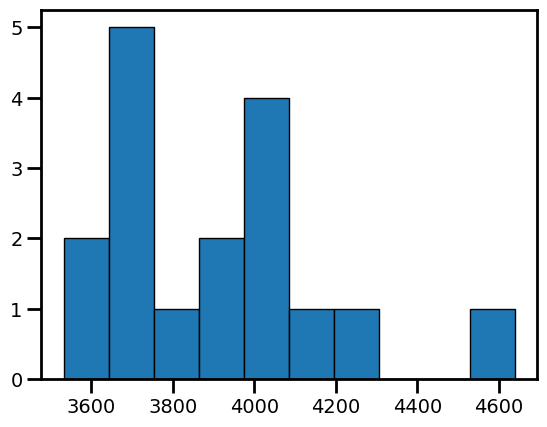

In [45]:
plt.hist(l_benchs[:-2], edgecolor='black')
plt.show()

In [51]:
min_lenght=3000
max_lenght=5000

## Run

In [43]:
min_lenght=3000
max_lenght=5000

Let it run in bunches:

In [40]:
th=4000

In [153]:
titles=[]
texts=[]
_round=0
while len(titles)<th:
    _titles, _texts = get_wikipedia_texts_v2(500)
    for i_t, _text in enumerate(_texts): 
        if len(_text)>=min_lenght and len(_text)<=max_lenght:
            texts.append(_text)
            titles.append(_titles[i_t])
    print(f'[{dt.datetime.now():%H:%M:%S}] round={_round:4}, len(titles)={len(titles):4}')
    _round+=1

[14:12:23] round=   0, len(titles)=   0
[14:16:27] round=   1, len(titles)= 126
[14:20:27] round=   2, len(titles)= 258
[14:24:25] round=   3, len(titles)= 384
[14:28:29] round=   4, len(titles)= 520
[14:32:34] round=   5, len(titles)= 660
[14:36:41] round=   6, len(titles)= 793
[14:40:45] round=   7, len(titles)= 928
[14:44:57] round=   8, len(titles)=1066
[14:49:01] round=   9, len(titles)=1184
[14:53:11] round=  10, len(titles)=1307
[14:57:22] round=  11, len(titles)=1446
[15:01:28] round=  12, len(titles)=1578
[15:05:35] round=  13, len(titles)=1698
[15:09:52] round=  14, len(titles)=1832
[15:14:06] round=  15, len(titles)=1962
[15:18:14] round=  16, len(titles)=2099
[15:22:19] round=  17, len(titles)=2246
[15:26:23] round=  18, len(titles)=2377
[15:30:36] round=  19, len(titles)=2510
[15:34:43] round=  20, len(titles)=2647
[15:39:04] round=  21, len(titles)=2771
[15:43:08] round=  22, len(titles)=2902
[15:47:07] round=  23, len(titles)=3038
[15:51:23] round=  24, len(titles)=3164


### Save texts

In [159]:
def title2filename(counter, title):
    return 'wikipedia_'+str(counter).zfill(4)+'_'+'_'.join(title.replace('/', '_').split(' '))+'.txt'

In [160]:
for i_t, title in enumerate(tqdm(titles)):
    file_name=title2filename(i_t, title)
    with open(BENCHMARK_FOLDER+file_name, 'w') as f:
        f.write(texts[i_t])

  0%|          | 0/4001 [00:00<?, ?it/s]

In [161]:
titles[435]

'Lola B08/60'